## Virtual Env

* First it is always adviced to make a new virtual environment and work withing that environment. 
* Use Python 12.x (x can be any subversion). Then remove the comment on the next step and install all the libraries mentioned, or just use the `requirements.txt` file.

Use `pip install -r requirements.txt`

## Installing required libraries

* Librosa
* Numpy
* Matplotlib
* Scikit-learn

In [4]:
pip install ipykernel librosa numpy matplotlib scikit-learn joblib pandas seaborn

## Importing Libraries
* `os` and `glob`: For file handling and pattern matching.
* `librosa`: For audio processing and feature extraction.
* `numpy`: For numerical operations.
* `pandas`: For data manipulation (not used in this script but commonly used in similar projects).
* `matplotlib.pyplot`: For plotting and visualizing features.
* `sklearn modules`: For machine learning tasks

In [5]:
import os
import glob
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import joblib

 ## Defining Emotions and Observed Emotions

* `emotions`: A dictionary mapping emotion codes to their descriptive names.
* `observed_emotions`: A list of emotions we want to recognize and classify.

In [6]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

observed_emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']

##  Feature Extraction Function

* `librosa.load`: Loads the audio file and returns the audio time series (y) and the sampling rate (sr).
* `np.array([])`: Initializes an empty numpy array to hold features.

#### MFCC(Mel-Frequency Cepstral Coefficient):
* `librosa.feature.mfcc`: Extracts MFCCs from the audio signal.
* `np.mean(..., axis=0)`: Averages MFCCs over time.
* `np.hstack`: Horizontally stacks features into a single array.

#### Chromagram:
* `librosa.stft`: Computes the Short-Time Fourier Transform (STFT) of the audio signal.
* `librosa.feature.chroma_stft`: Computes the chromagram (a representation of the 12 pitch classes).

#### Mel-scaled Spectrogram:
* `librosa.feature.melspectrogram`: Computes the mel-scaled spectrogram.

#### Spectral Contrast:
* `librosa.feature.spectral_contrast`: Computes the spectral contrast, which describes the difference in amplitude between peaks and valleys in the sound spectrum.

#### Tonnetz:
* `librosa.feature.tonnetz`: Computes the Tonnetz features, which capture tonal centroid features from harmonic signal.

In [7]:
def extract_features(file_name):
    y, sr = librosa.load(file_name, sr=None)
    features = np.array([])
    
    # Extract MFCC
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
    features = np.hstack((features, mfccs))
    
    # Extract Chromagram
    stft = np.abs(librosa.stft(y))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    features = np.hstack((features, chroma))
    
    # Extract Mel-scaled spectrogram
    mel = np.mean(librosa.feature.melspectrogram(y=y, sr=sr).T, axis=0)
    features = np.hstack((features, mel))
    
    # Extract Spectral Contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
    features = np.hstack((features, contrast))
    
    # Extract Tonnetz (Tonal Centroid)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
    features = np.hstack((features, tonnetz))
    
    return features

## Loading and Balancing the Dataset

* `glob.glob`: Finds all .wav files in the specified directory.
* **Feature extraction**: For each file, extract features and append them to x, and the emotion label to y.


 **Balancing the dataset**:
* **Count samples**: Determine how many samples exist for each emotion.
* **Determine minimum samples**: Find the emotion with the fewest samples.
* **Select samples**: Ensure an equal number of samples for each emotion to avoid bias.


* `train_test_split`: Splits the balanced dataset into training and testing sets.


##### NOTE: Navigate to the folder that contains the dataset and add the suffix expression as shown in the code cell below.

In [48]:
def load_data(test_size):
    x, y = [], []
    for file in glob.glob("C:\\ML 2024\\speech-emotion-recognition-ravdess-data\\Actor_*\\*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature = extract_features(file)
        x.append(feature)
        y.append(emotion)
    
    # Balance the dataset
    min_samples = min([y.count(emotion) for emotion in observed_emotions])
    balanced_x, balanced_y = [], []
    
    for emotion in observed_emotions:
        count = 0
        for i in range(len(y)):
            if y[i] == emotion and count < min_samples:
                balanced_x.append(x[i])
                balanced_y.append(y[i])
                count += 1
    
    return train_test_split(np.array(balanced_x), balanced_y, test_size=test_size, random_state=9)


#### Split the data into train (80%) and test (20%)

In [9]:
x_train, x_test, y_train, y_test = load_data(test_size=0.2)

## Feature Visualization

* `plot_features`: Plots features to visualize their distribution.
#### visualize_features:
* **MFCC**: Plots the mean of MFCC features.
* **Chromagram**: Plots the mean of Chromagram features.
* **Mel-scaled spectrogram**: Plots the mean of Mel-scaled spectrogram features.
* **Spectral Contrast**: Plots the mean of Spectral Contrast features.
* **Tonnetz**: Plots the mean of Tonnetz features.

#### Explanation of the Indices
* `x[:, :13]` - MFCC features (13 features)
* `x[:, 13:25]` - Chromagram features (12 features)
* `x[:, 25:125]` - Mel-scaled spectrogram features (100 features) (The number of Mel bands can vary, but here we assume 100 Mel bands for illustration)
* `x[:, 125:132]` - Spectral contrast features (7 features)
* `x[:, 132:138]` - Tonnetz features (6 features)

In [11]:
# Function to plot features
def plot_features(features, title):
    plt.figure(figsize=(10, 4))
    plt.plot(features)
    plt.title(title)
    plt.xlabel('Feature Index')
    plt.ylabel('Feature Value')
    plt.show()

# Visualize each type of feature
def visualize_features(x, feature_name):
    # Extract MFCC
    mfccs = x[:, :13]
    plot_features(np.mean(mfccs, axis=0), f"{feature_name} - MFCC")
    
    # Extract Chromagram
    chroma = x[:, 13:25]
    plot_features(np.mean(chroma, axis=0), f"{feature_name} - Chromagram")
    
    # Extract Mel-scaled spectrogram
    mel = x[:, 25:125]
    plot_features(np.mean(mel, axis=0), f"{feature_name} - Mel-scaled Spectrogram")
    
    # Extract Spectral Contrast
    contrast = x[:, 125:132]
    plot_features(np.mean(contrast, axis=0), f"{feature_name} - Spectral Contrast")
    
    # Extract Tonnetz
    tonnetz = x[:, 132:138]
    plot_features(np.mean(tonnetz, axis=0), f"{feature_name} - Tonnetz")

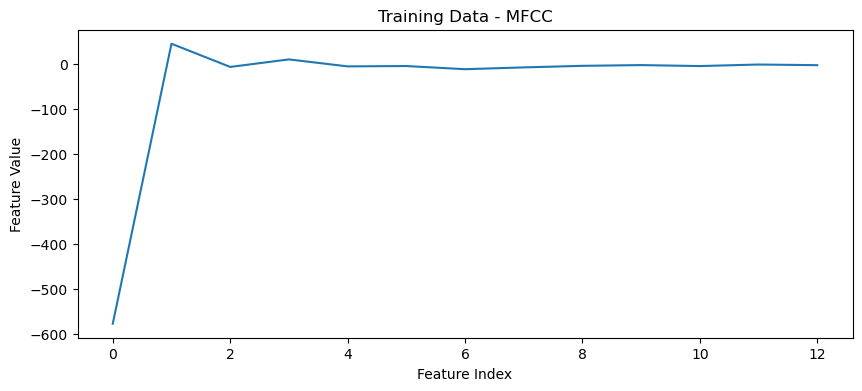

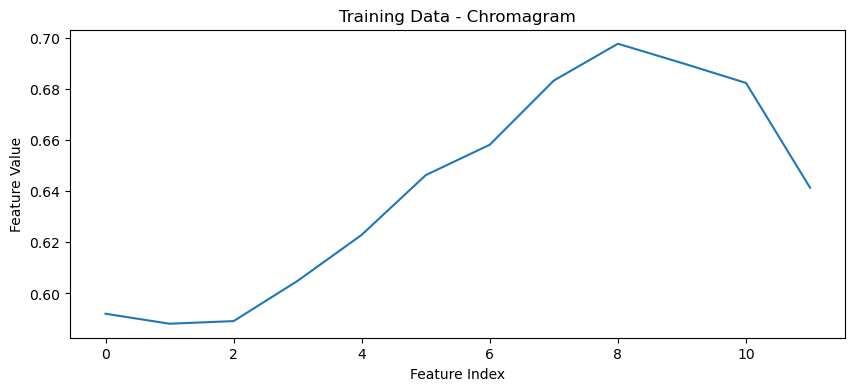

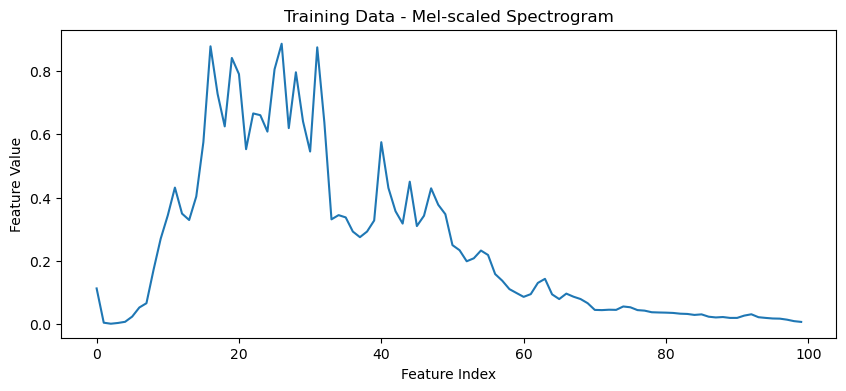

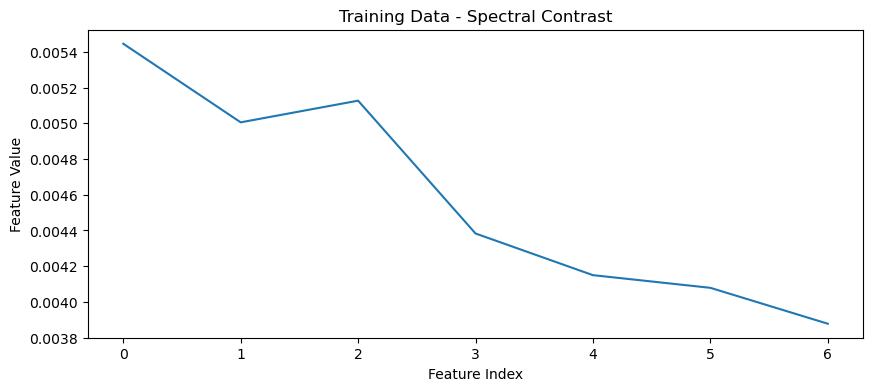

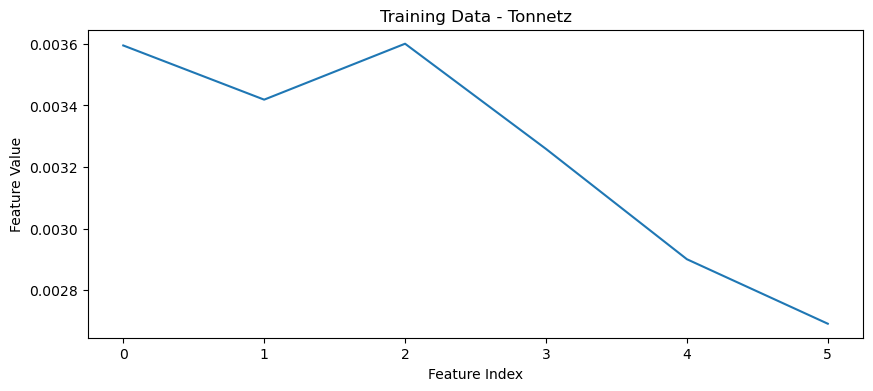

In [12]:
visualize_features(x_train, "Training Data")

## Encoding Labels and Standardizing Features

#### Label Encoding:
* **LabelEncoder**: Converts emotion labels from strings to numerical values.

#### Standardization:
* **StandardScaler**: Standardizes features by removing the mean and scaling to unit variance, which improves model performance.

In [13]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Buliding the MLP Model

#### MLPClassifier:
* `hidden_layer_sizes`: Defines the architecture of the MLP with three layers of 256, 128, and 64 neurons respectively.
* `activation`: Uses the ReLU activation function.
* `solver`: Uses Adam optimizer.
* `max_iter`: Sets the maximum number of iterations for training.

#### Training and Evaluation:
* `mlp.fit`: Trains the model on the scaled training data.
* `mlp.score`: Evaluates the model’s accuracy on the test data.

In [15]:
mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam', max_iter=500, random_state=9)

In [18]:
mlp.fit(x_train_scaled, y_train_encoded)
print("Model Training Completed")

Model Training Completed


In [19]:
accuracy = mlp.score(x_test_scaled, y_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 59.09%


#### Saving and Loading the Model
* **Saving the model**: By using `joblib.dump`, you store the trained model to a file, which can be reused later. This is useful for persisting models after training, allowing you to avoid retraining each time you want to use the model.
* **Loading the model**: By using `joblib.load`, you retrieve the stored model from the file and load it into your program, making it available for making predictions or further evaluations.

In [22]:
joblib.dump(mlp, 'mlp_emotion_classifier_model1.joblib')
print("MLP_Model1 saved successfully.")

MLP_Model1 saved successfully.


In [23]:
mlp = joblib.load('mlp_emotion_classifier_model1.joblib')
print("Model loaded successfully.")

Model loaded successfully.


## Fine Tuning HParams

* There are many ways of doing this, but We shall see RandomSearchCV.

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define the parameter distributions
param_dist = {
    'hidden_layer_sizes': [(256, 128, 64), (512, 256, 128), (128, 64, 32)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'batch_size': [32, 64, 128],
    'max_iter': [200, 500, 1000]
}

mlp = MLPClassifier(random_state=9)

random_search_model = RandomizedSearchCV(estimator=mlp, param_distributions=param_dist, n_iter=50, n_jobs=-1, cv=3, verbose=2, random_state=9)

random_search_model.fit(x_train_scaled, y_train_encoded)

print("Best parameters found: ", random_search_model.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters found:  {'solver': 'sgd', 'max_iter': 500, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (512, 256, 128), 'batch_size': 32, 'activation': 'relu'}


In [25]:
best_model = random_search_model.best_estimator_

accuracy = best_model.score(x_test_scaled, y_test_encoded)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 62.34%


In [26]:
joblib.dump(best_model, 'mlp_emotion_classifier_best_model2.joblib')
print("Best MLP model found and saved successfully.")

Best MLP model found and saved successfully.


In [27]:
best_model = joblib.load('mlp_emotion_classifier_best_model2.joblib')
print("Model Loaded successfully")

Model Loaded successfully


## Make Predictions with both models


In [28]:
mlp.fit(x_train_scaled, y_train_encoded)

C:\Users\Sumuk\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=9)

In [29]:
y_pred = mlp.predict(x_test_scaled)
y_pred_best = best_model.predict(x_test_scaled)

## Metrics

* What are metrics and why do we need them?
    * Metrics are basically measures of how good your model actually is.
    * They can be used for comparative studies between multiple trials at training a model and also checking for any False Positive and False Negative outputs which can affect the `precision` and `F1-Scores`.
    * There are various types but here, we will be using 3 metrics and these are quite common for Machine Learning Models. They are:
        * Precision
        * Recall
        * F1 Score
    * Formulae for all are mentioned below and all the values for `TP(True Positive)`, `FP(False Positive)`, `TN(True Negative)` and `FN(False Negative)` are obtained from the `confusion matrix`.


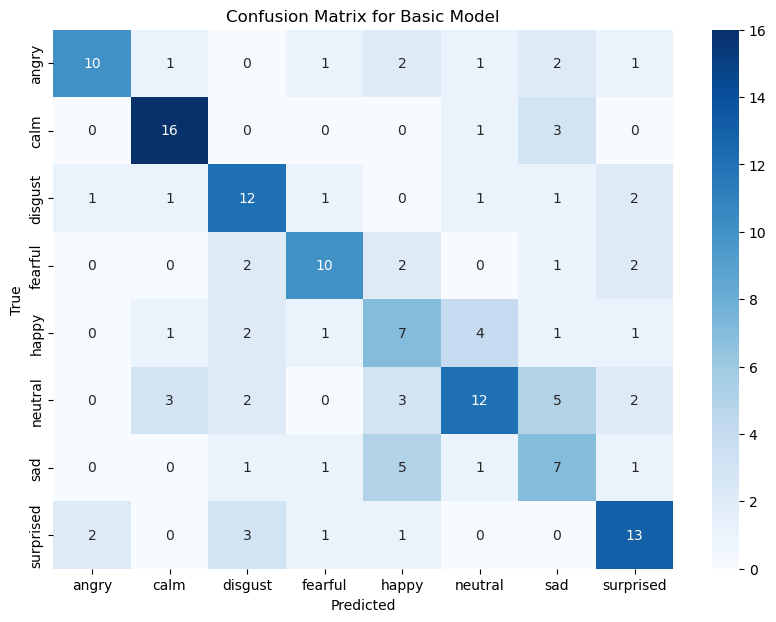

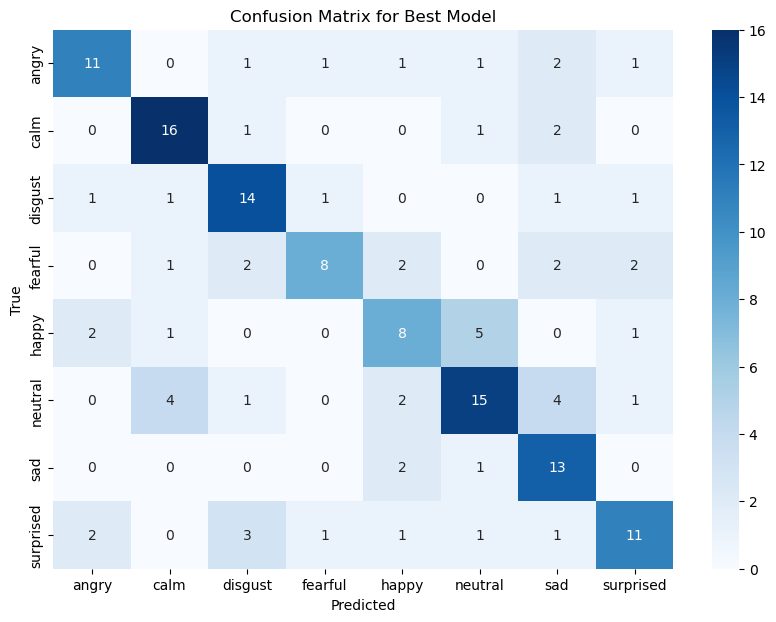

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

cm = confusion_matrix(y_test_encoded, y_pred)
plot_confusion_matrix(cm, label_encoder.classes_, title='Confusion Matrix for Basic Model')

cm_best = confusion_matrix(y_test_encoded, y_pred_best)
plot_confusion_matrix(cm_best, label_encoder.classes_, title='Confusion Matrix for Best Model')

Now, here we will evaluate for both the models. The initial `mlp` model and also for the `best_model` found by HParam tuning.

In [31]:
from sklearn.metrics import classification_report

In [32]:
y_pred = mlp.predict(x_test_scaled)
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

       angry       0.77      0.56      0.65        18
        calm       0.73      0.80      0.76        20
     disgust       0.55      0.63      0.59        19
     fearful       0.67      0.59      0.62        17
       happy       0.35      0.41      0.38        17
     neutral       0.60      0.44      0.51        27
         sad       0.35      0.44      0.39        16
   surprised       0.59      0.65      0.62        20

    accuracy                           0.56       154
   macro avg       0.57      0.56      0.56       154
weighted avg       0.58      0.56      0.57       154



In [33]:
# Best Model
y_pred_best = best_model.predict(x_test_scaled)

best_report = classification_report(y_test_encoded, y_pred_best, target_names=label_encoder.classes_)
print("Best Model Classification Report:\n")
print(best_report)

Best Model Classification Report:

              precision    recall  f1-score   support

       angry       0.69      0.61      0.65        18
        calm       0.70      0.80      0.74        20
     disgust       0.64      0.74      0.68        19
     fearful       0.73      0.47      0.57        17
       happy       0.50      0.47      0.48        17
     neutral       0.62      0.56      0.59        27
         sad       0.52      0.81      0.63        16
   surprised       0.65      0.55      0.59        20

    accuracy                           0.62       154
   macro avg       0.63      0.63      0.62       154
weighted avg       0.63      0.62      0.62       154



## K-Fold Cross Validation

* K-Fold cross-validation is a statistical method used to evaluate the performance of a machine learning model. 
* It involves partitioning the original dataset into `K subsets` or `folds`. 

In [34]:
from sklearn.model_selection import KFold, cross_val_score

In [35]:
kf = KFold(n_splits=5, shuffle=True, random_state=9)

mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam', max_iter=500, random_state=9)

mlp_scores = cross_val_score(mlp, x_train_scaled, y_train_encoded, cv=kf)

In [36]:
print("MLP Cross-Validation Accuracy Scores: ", mlp_scores)
print("MLP Average Accuracy: ", np.mean(mlp_scores))

MLP Cross-Validation Accuracy Scores:  [0.52845528 0.56910569 0.53658537 0.58536585 0.60655738]
MLP Average Accuracy:  0.5652139144342263


## Now, How about a comparitive study?

* For the ease of understanding and for a good revision, I have mentioned even the MLP model again.
* When it comes to the syntax of importing the model and using it, they all look nearly the same to sight.

### MLP

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

mlp = MLPClassifier(hidden_layer_sizes=(256, 128, 64), activation='relu', solver='adam', max_iter=500, random_state=9)
mlp.fit(x_train_scaled, y_train_encoded)

y_pred_mlp = mlp.predict(x_test_scaled)
accuracy_mlp = mlp.score(x_test_scaled, y_test_encoded)
print(f"MLP Test Accuracy: {accuracy_mlp * 100:.2f}%")


MLP Test Accuracy: 59.09%


In [38]:
print("MLP Classification Report:\n", classification_report(y_test_encoded, y_pred_mlp, target_names=label_encoder.classes_))

MLP Classification Report:
               precision    recall  f1-score   support

       angry       0.69      0.50      0.58        18
        calm       0.73      0.80      0.76        20
     disgust       0.68      0.68      0.68        19
     fearful       0.70      0.41      0.52        17
       happy       0.44      0.41      0.42        17
     neutral       0.52      0.48      0.50        27
         sad       0.40      0.75      0.52        16
   surprised       0.74      0.70      0.72        20

    accuracy                           0.59       154
   macro avg       0.61      0.59      0.59       154
weighted avg       0.61      0.59      0.59       154



In [39]:
print(label_encoder.classes_)

['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [40]:
unique_test_labels = np.unique(y_test_encoded)
print("Unique classes in y_test_encoded:", unique_test_labels)

# Filter label_encoder.classes_ to only include classes present in y_test_encoded
present_labels = [label for label in label_encoder.classes_ if label_encoder.transform([label])[0] in unique_test_labels]
print("Present labels:", present_labels)

Unique classes in y_test_encoded: [0 1 2 3 4 5 6 7]
Present labels: ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprised']


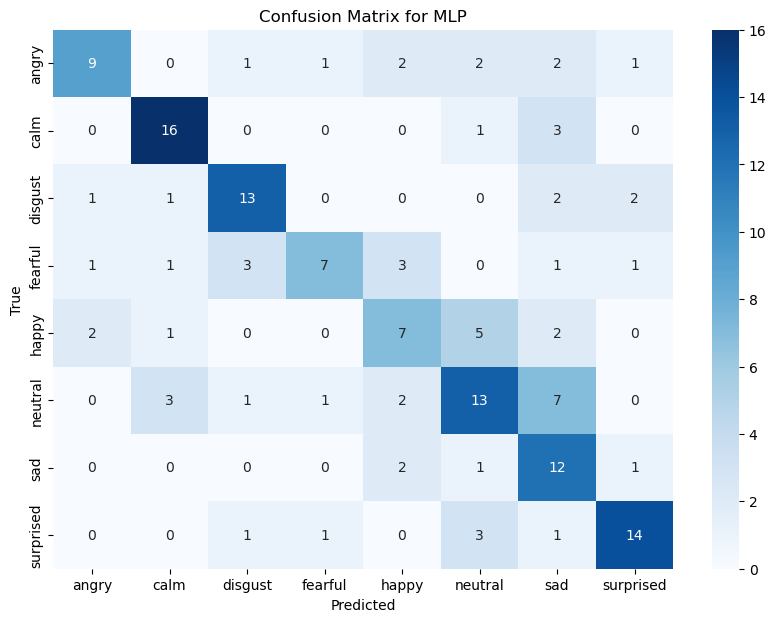

In [41]:
cm_mlp = confusion_matrix(y_true=y_test_encoded, y_pred=y_pred_mlp, labels=unique_test_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_mlp, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for MLP')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### SVM Classifier => Support Vector Machine

* I've attached a link. Do go and check it out. It explains the basics of SVM very well. 

* In short, A `Support Vector Machine` (SVM) is a powerful `classification` algorithm that finds the optimal boundary, known as the hyperplane, which best separates data points of different classes. It uses two support vectors which are critical data points closest to the boundary, which define and maximize the boundary. This ensures that an optimal boundary is set so that it can separate the two classes accurately.

* https://www.geeksforgeeks.org/support-vector-machine-algorithm/

In [42]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', random_state=9)
svm.fit(x_train_scaled, y_train_encoded)

y_pred_svm = svm.predict(x_test_scaled)
accuracy_svm = svm.score(x_test_scaled, y_test_encoded)
print(f"SVM Test Accuracy: {accuracy_svm * 100:.2f}%")

SVM Test Accuracy: 50.65%


In [43]:
print("SVM Classification Report:\n", classification_report(y_test_encoded, y_pred_svm, target_names=label_encoder.classes_))

SVM Classification Report:
               precision    recall  f1-score   support

       angry       0.47      0.50      0.49        18
        calm       0.67      0.70      0.68        20
     disgust       0.48      0.58      0.52        19
     fearful       0.50      0.53      0.51        17
       happy       0.28      0.29      0.29        17
     neutral       0.45      0.37      0.41        27
         sad       0.48      0.69      0.56        16
   surprised       0.90      0.45      0.60        20

    accuracy                           0.51       154
   macro avg       0.53      0.51      0.51       154
weighted avg       0.53      0.51      0.51       154



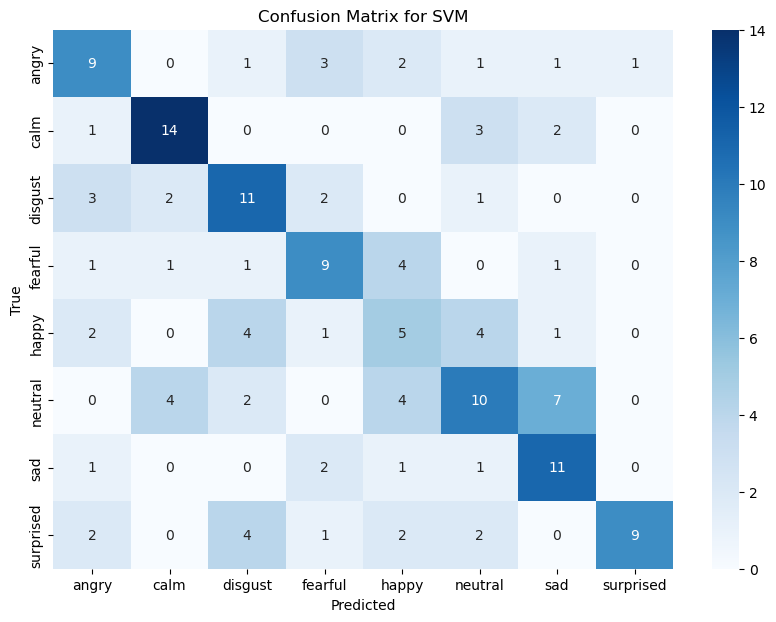

In [44]:
cm_svm = confusion_matrix(y_true=y_test_encoded, y_pred=y_pred_svm, labels=np.arange(len(label_encoder.classes_)))
plt.figure(figsize=(10, 7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for SVM')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### KNN Classifier

* K-Nearest Neighbors, is also another Supervised Classification algorithm. Basically, we define the number of neighbors first, then find the distances of the upcoming points from the rest of the points. Then, segregate the points after finding the `lowest distance`. Distances are of many types but the common ones are Euclidean, Manhattan, and Minkowski distances. 

* Then, we will find the new centroid (collective centroid) of that cluster and start from there again, till all the values are covered.

* Note: Don't confuse this with K-Means clustering, which is an Unsupervised Algorithm.

In [45]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=8)
knn.fit(x_train_scaled, y_train_encoded)

y_pred_knn = knn.predict(x_test_scaled)
accuracy_knn = knn.score(x_test_scaled, y_test_encoded)
print(f"KNN Test Accuracy: {accuracy_knn * 100:.2f}%")

KNN Test Accuracy: 38.31%


In [46]:
print("KNN Classification Report:\n", classification_report(y_test_encoded, y_pred_knn, target_names=label_encoder.classes_))

KNN Classification Report:
               precision    recall  f1-score   support

       angry       0.26      0.28      0.27        18
        calm       0.47      0.45      0.46        20
     disgust       0.30      0.42      0.35        19
     fearful       0.38      0.29      0.33        17
       happy       0.19      0.18      0.18        17
     neutral       0.58      0.56      0.57        27
         sad       0.20      0.19      0.19        16
   surprised       0.58      0.55      0.56        20

    accuracy                           0.38       154
   macro avg       0.37      0.36      0.36       154
weighted avg       0.39      0.38      0.38       154



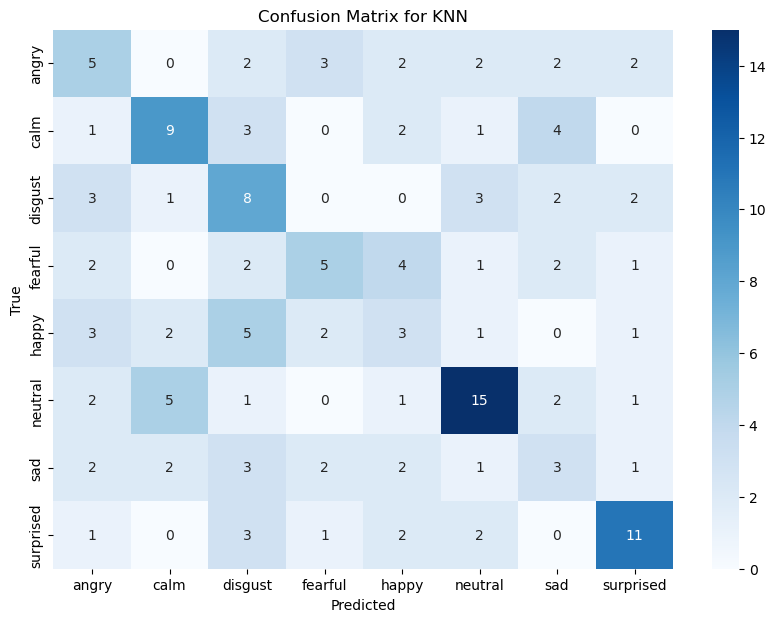

In [47]:
integer_labels = np.arange(len(label_encoder.classes_))
cm_knn = confusion_matrix(y_true=y_test_encoded, y_pred=y_pred_knn, labels=integer_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for KNN')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()